In [248]:
import datetime as datetime
import pandas as pd
import numpy as np
import datetime 
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

#Permite ver los graficos sin colocar plt.show
%matplotlib inline 

#plt.style.use('default')
#plt.rcParams['figure.figsize'] = (15, 25)

In [249]:
propiedades = pd.read_csv("properati-AR-2017-08-01-properties-sell.csv", low_memory = False)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 27 columns):
id                            187482 non-null object
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           12502

In [250]:
#FILTRADO DE DATOS

In [251]:
#Convierto la fecha de crecion en un datetime64[ns]
propiedades['created_on'] = pd.to_datetime(propiedades['created_on'])

#Se procede a filtrar las propiedades anteriores al 2014
propiedades = propiedades[propiedades.created_on.dt.year > 2013]

In [252]:
#Obtengo los datos de Capital Federal y de GBA
propiedadesCapGBA = propiedades.loc[(propiedades.state_name.str.contains('Capital Federal') | propiedades.state_name.str.contains('G.B.A') ) & propiedades.operation.str.contains('sell') , ['created_on','operation', 'property_type', 'state_name', 'place_name', 'lat', 'lon', 'price', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'description']]
propiedadesCapGBA = propiedadesCapGBA.loc[propiedadesCapGBA['place_name'] != 'Capital Federal', :]

In [253]:
#Filtro los datos cuyo precio por mt2 sea menor que 10000 y mayor a 100
propiedadesMenor10K = propiedadesCapGBA.loc[propiedadesCapGBA['price_usd_per_m2'] > 100, :].loc[propiedadesCapGBA['price_usd_per_m2'] < 10000,:]

In [254]:
#Filtro los registros que no tienen latitud ni longitud.
propiedadesMenor10K = propiedadesMenor10K.loc[propiedadesMenor10K['lat'].notnull() & propiedadesMenor10K['lat'].notnull(), :]

In [255]:
#Quiero ver la media y la mediana del mt2 en usd por barrio como tmb la cantidad de propiedades en cada barrio.
groupbyPlace = propiedadesMenor10K[['place_name', 'price_usd_per_m2']].groupby('place_name', as_index = False)['price_usd_per_m2']\
.agg({'media_por_barrio': np.mean, 'mediana_por_barrio': np.median, 'cant_prop': np.size})
groupbyPlace = groupbyPlace.loc[groupbyPlace['cant_prop'] > 4, :]

propiedadesPorBarrio = pd.merge(propiedadesMenor10K, groupbyPlace, on = 'place_name')

In [256]:
propiedadesPorBarrio = propiedadesPorBarrio.loc[propiedadesPorBarrio.surface_total_in_m2 <= 1000, :]

In [257]:
propiedadesPorBarrio['surface_total_in_m2'].describe()

count    46017.000000
mean       151.593781
std        162.753295
min         10.000000
25%         50.000000
50%         84.000000
75%        196.000000
max       1000.000000
Name: surface_total_in_m2, dtype: float64

In [258]:
#RELACION ENTRE PRECIO POR M2 y SUPERFICIE TOTAL EN M2

In [259]:
groupbySurface = propiedadesPorBarrio.groupby(pd.cut(propiedadesPorBarrio['surface_total_in_m2'], range(0, 1001, 100)), as_index= False)
groupbySurface['price_usd_per_m2'].agg(['mean','median' ,'size'])

#Se puede ver claramente que el precio por m2 no esta relacionado con la cantidad de mt2 que tenga la propiedad.

mean       median   size
surface_total_in_m2                                 
(0, 100]             2295.132021  2166.666667  26097
(100, 200]           2111.263947  1788.804356   9166
(200, 300]           1630.663168  1260.686883   5016
(300, 400]           1382.642545  1014.605544   2478
(400, 500]           1354.791417   940.000000   1222
(500, 600]           1089.809137   687.964841    634
(600, 700]           1003.368900   625.000000    413
(700, 800]            680.776104   415.584416    406
(800, 900]            595.955327   415.700307    332
(900, 1000]           696.343950   390.000000    253

In [260]:
#Determino si el precio por mt2 esta determinado por los mt2 de la propiedad.
#Para eso veo la relacion Departamentos vs Casas
#Los departamentos son mas caras que las casas en la mayoria de los barrios.



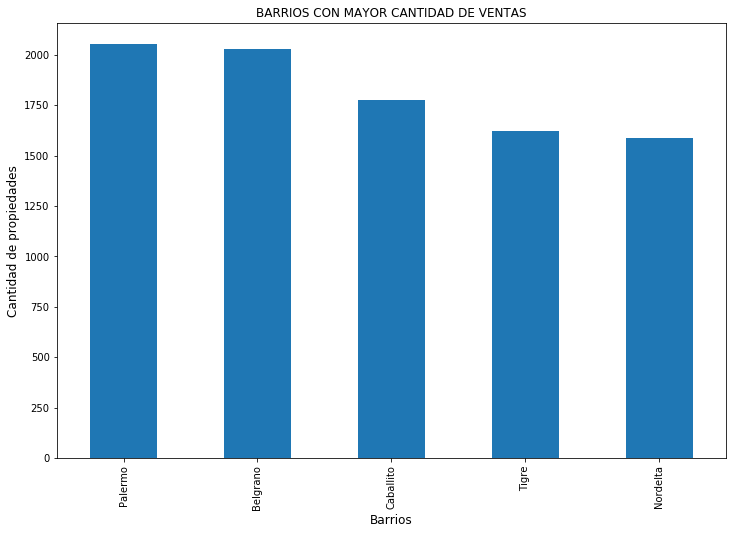

In [295]:
#Quiero ver los barrios que tienen mayor cantidad de ventas
ventasPorBarrio = propiedadesPorBarrio.groupby('place_name')
ventasPorBarrioTop5 = ventasPorBarrio['created_on'].count().sort_values(ascending = False).head()
ventasPorBarrioTop5.plot(kind = 'bar', figsize= (12, 8))

plt.ylabel('Cantidad de propiedades', fontsize = 12);
plt.xlabel('Barrios', fontsize = 12);
plt.title('BARRIOS CON MAYOR CANTIDAD DE VENTAS')

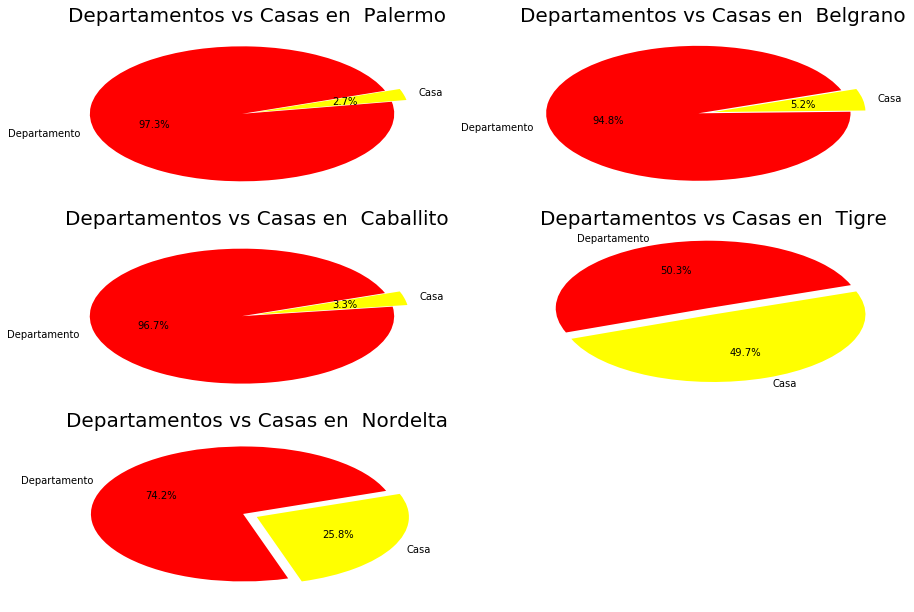

In [296]:
#Veo que tipo de propiedad se vendio mas en los barrios con mayores ventas

dataTipoProp = [ventasPorBarrio.get_group('Palermo'), ventasPorBarrio.get_group('Belgrano'), ventasPorBarrio.get_group('Caballito'), ventasPorBarrio.get_group('Tigre'), ventasPorBarrio.get_group('Nordelta')]
dataNombres = ['Palermo', 'Belgrano', 'Caballito', 'Tigre', 'Nordelta']
nombres = ['Departamento', 'Casa']

plt.figure(figsize=(15, 18));

for i in range(len(dataTipoProp)):
    tam = []
    tam.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'apartment', :]['created_on'].count())
    tam.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'house', :]['created_on'].count()) 
    
    ax = plt.subplot(521 + i );
    plt.pie(tam, labels = nombres, autopct='%1.1f%%', startangle = 20, colors=['red', 'yellow'], explode=(0.1, 0))
    plt.title('Departamentos vs Casas en  ' + dataNombres[i], fontsize = 20);
   

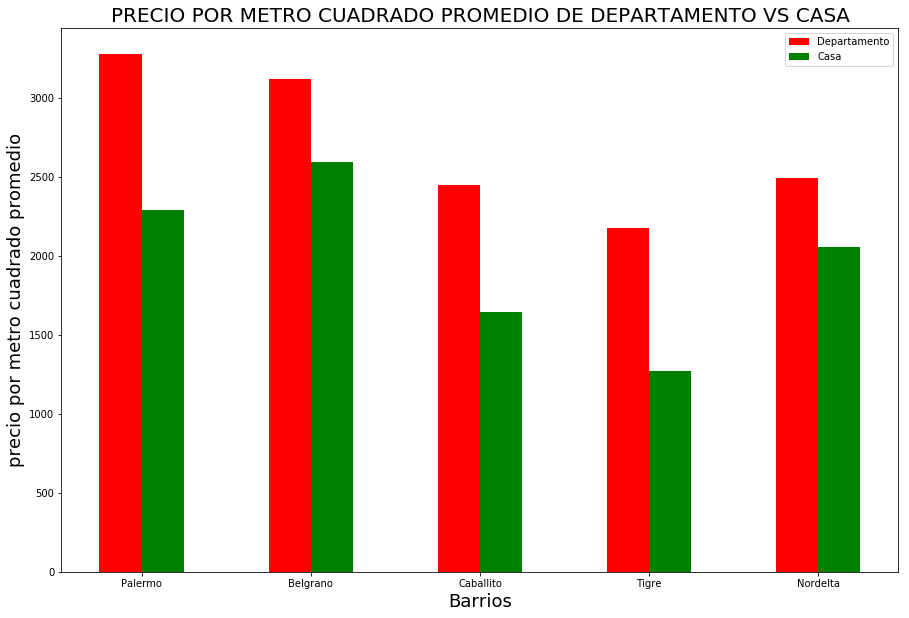

In [264]:
deptosMean = []
casasMean = []

plt.figure(figsize=(15, 10));

for i in range(len(dataTipoProp)):
    deptosMean.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'apartment', :]['price_usd_per_m2'].mean())
    casasMean.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'house', :]['price_usd_per_m2'].mean())

x = np.arange(5)
plt.bar(x, deptosMean, color = 'red', width=0.25 );
plt.bar(x + 0.25, casasMean, color ='green',  width=0.25 );
plt.xticks(x + 0.125, dataNombres, size = 'medium')
plt.title('PRECIO POR METRO CUADRADO PROMEDIO DE DEPARTAMENTO VS CASA', fontsize = 20)
plt.xlabel('Barrios', fontsize = 18)
plt.ylabel('precio por metro cuadrado promedio', fontsize = 18)
plt.legend(nombres)

In [265]:
#VENTAS EN LOS BARRIOS 

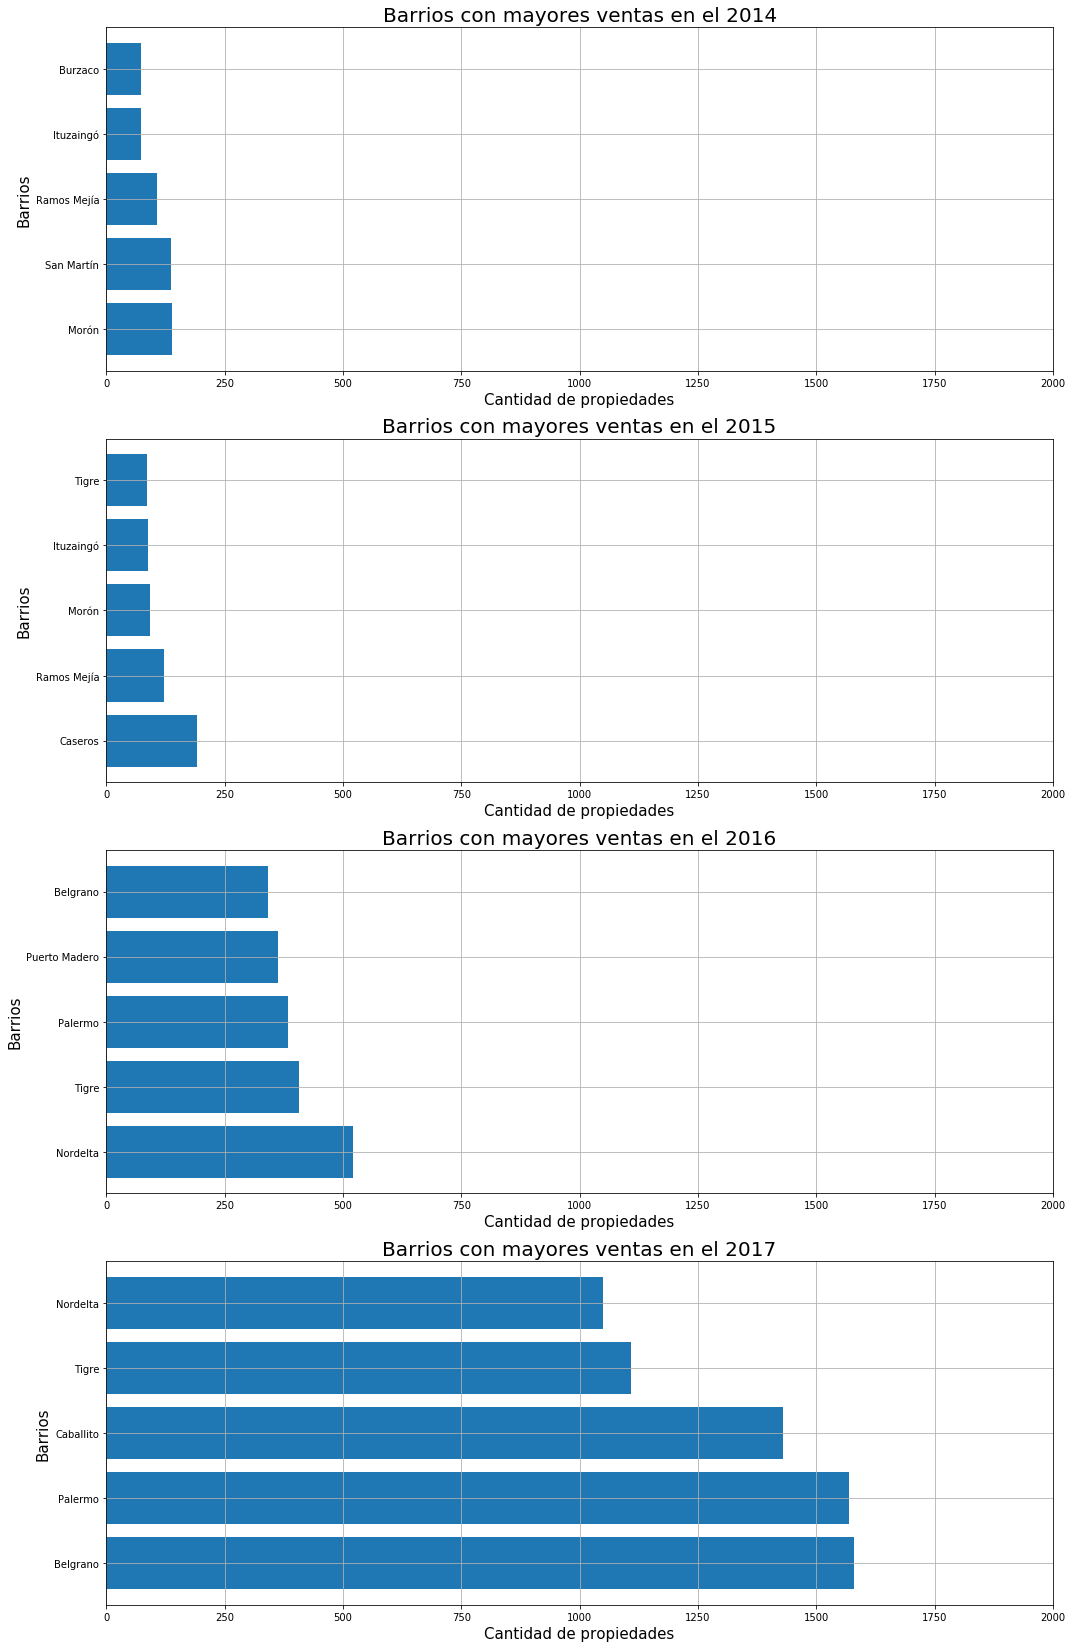

In [266]:
#Veo cuales son los barrios que obtuvieron la mayor cantidad de ventas en los ultimos 4 anios

barrios2017 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2017]
barrios2016 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2016]
barrios2015 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2015]
barrios2014 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2014]

barrios = [barrios2014, barrios2015, barrios2016, barrios2017]
barrios_anios = ['2014', '2015', '2016', '2017']

plt.figure(figsize=(15, 23));

for i in range(len(barrios)):
    barrios[i] = barrios[i].groupby('place_name')['cant_prop'].count().sort_values(ascending=False)
    
    ax = plt.subplot(411 + i );
    ax.set_xlim([0, 2000]);

    plt.grid(True);
    plt.title('Barrios con mayores ventas en el ' + barrios_anios[i], fontsize = 20);
    plt.xlabel('Cantidad de propiedades', fontsize = 15);
    plt.ylabel('Barrios', fontsize = 15);
    ax.barh([j for j in range(5)], [valor for valor in barrios[i][:5].values], 
            tick_label=[viaje for viaje in barrios[i][:5].index.values]);
plt.tight_layout();


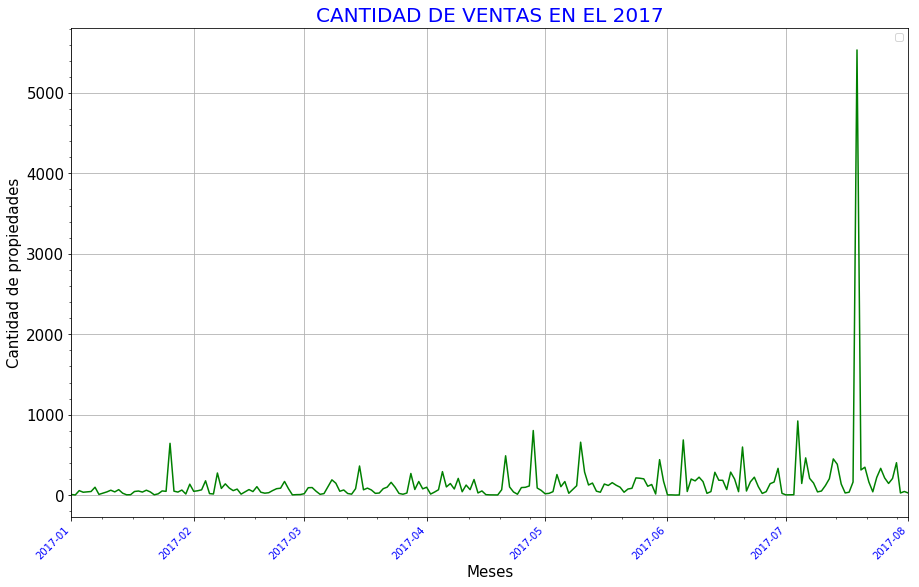

In [267]:
#Busco el mes con mayor venta en el 2017

dias2017 = barrios2017.groupby('created_on')['cant_prop'].count()

dias2017.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL 2017', fontsize = 20, color = 'blue')  
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

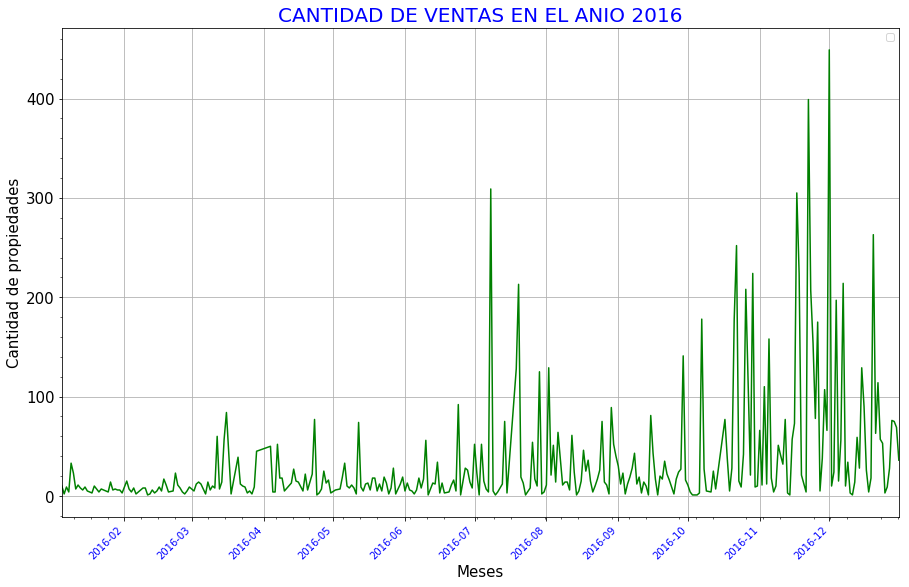

In [268]:
#Busco el mes con mayor venta en el 2016
dias = [np.array(calendar.mdays)[0:i].sum() + 1 for i in np.arange(12) + 1] 
meses = calendar.month_name[1:13]


dias2016 = barrios2016.groupby('created_on')['cant_prop'].count()

dias2016.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2016', fontsize = 20, color = 'blue')
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

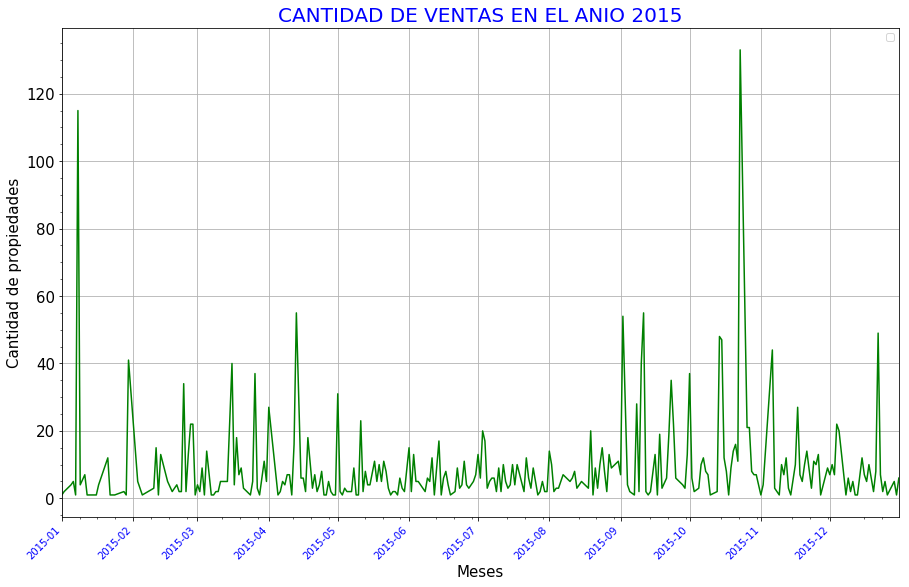

In [269]:
#Busco el mes con mayor venta en el 2015
dias2015 = barrios2015.groupby('created_on')['cant_prop'].count()

dias2015.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2015', fontsize = 20, color = 'blue')  # Colocamos el título del gráfico
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

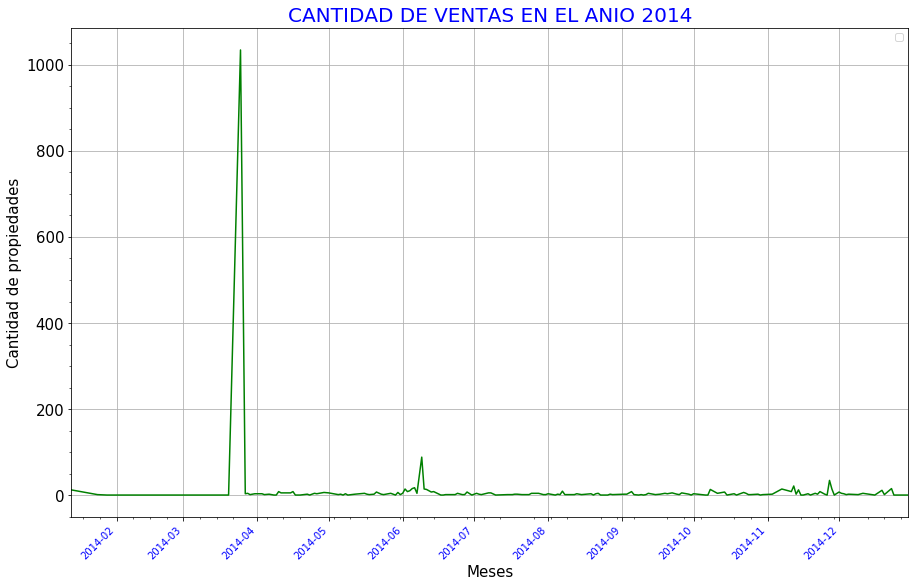

In [270]:
#Busco el mes con mayor venta en el 2014
dias2014 = barrios2014.groupby('created_on')['cant_prop'].count()

dias2014.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2014', fontsize = 20, color = 'blue')  
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

In [271]:
#Relacion entre la localizacion de la propiedad y su precio por m2

In [272]:
#Funcion para calcular distancias entre coordenadas (lat, lon)
from math import sin,cos,sqrt,asin,pi

#Formula del Harvesine sacada de
#https://joseguerreroa.wordpress.com/2012/11/13/distancia-entre-dos-puntos-de-la-superficie-terrestre-mediante-la-formula-de-haversine-con-python/
#coord = (lat, long)
def distancia(coord1, coord2):
    rTierra = 6374000 #metros
    c = pi/180 #para pasar a raddianes
    d = 2*rTierra*asin(sqrt(sin(c*(coord2[0]-coord1[0])/2)**2 + cos(c*coord1[0])*cos(c*coord2[0])*sin(c*(coord2[1]-coord1[1])/2)**2))
    return d

def obtener_geoPos(reg):
    lat, lon = reg
    return lat,lon

In [273]:
#Obtengo la latitud y longitud en una tupla.
propiedadesDistancia = propiedadesPorBarrio.copy(deep=True)
propiedadesDistancia['geoPos'] = propiedadesDistancia.loc[:,['lat', 'lon']].apply(obtener_geoPos, axis = 1)

In [274]:
def obtener_distancia_al_centro(geoPos):
    centro = (-34.608056,  -58.370278)# Se utilizo las coordenadas de la Casa Rosada
    return distancia(geoPos, centro)

In [277]:
propiedadesDistanciaCentro = propiedadesDistancia.copy(deep = True)
propiedadesDistanciaCentro.loc[:,'distancia_al_centro'] = propiedadesDistanciaCentro.loc[:, 'geoPos'].apply(obtener_distancia_al_centro)
propiedadesDistanciaCentro = propiedadesDistanciaCentro.loc[propiedadesDistanciaCentro.distancia_al_centro < 64000, :]

In [278]:
propiedadesDistancia

created_on operation property_type                state_name  \
1     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
2     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
3     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
4     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
5     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
6     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
7     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
8     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
9     2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
10    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
11    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
13    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
14    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
15    2014-03-25      sell     apartment  Bs.As. G.B.A. Zona Norte   
16    2014-03-25      sell     apartment  Bs.As. G.B.A. Zona Norte   
17    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
18    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
19    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
20    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
21    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
22    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
23    2014-03-25      sell         house  Bs.As. G.B.A. Zona Norte   
24    2014-03-25      sell     apartment  Bs.As. G.B.A. Zona Norte   
25    2014-06-09      sell     apartment  Bs.As. G.B.A. Zona Norte   
26    2014-06-09      sell     apartment  Bs.As. G.B.A. Zona Norte   
27    2014-06-09      sell         house  Bs.As. G.B.A. Zona Norte   
28    2014-06-09      sell         house  Bs.As. G.B.A. Zona Norte   
30    2014-11-27      sell         house  Bs.As. G.B.A. Zona Norte   
31    2014-12-11      sell     apartment  Bs.As. G.B.A. Zona Norte   
33    2015-03-01      sell         house  Bs.As. G.B.A. Zona Norte   
...          ...       ...           ...                       ...   
46653 2017-07-14      sell     apartment  Bs.As. G.B.A. Zona Norte   
46654 2017-05-18      sell         house  Bs.As. G.B.A. Zona Norte   
46655 2017-05-18      sell         house  Bs.As. G.B.A. Zona Norte   
46656 2017-05-18      sell         house  Bs.As. G.B.A. Zona Norte   
46657 2017-06-05      sell         house  Bs.As. G.B.A. Zona Norte   
46658 2017-06-05      sell         house  Bs.As. G.B.A. Zona Norte   
46659 2017-06-08      sell         house  Bs.As. G.B.A. Zona Norte   
46660 2017-06-10      sell         house  Bs.As. G.B.A. Zona Norte   
46661 2017-07-28      sell         house  Bs.As. G.B.A. Zona Norte   
46662 2017-05-21      sell         house  Bs.As. G.B.A. Zona Norte   
46663 2017-05-25      sell         house  Bs.As. G.B.A. Zona Norte   
46664 2017-05-28      sell         house  Bs.As. G.B.A. Zona Norte   
46665 2017-06-05      sell         house  Bs.As. G.B.A. Zona Norte   
46666 2017-06-07      sell         house  Bs.As. G.B.A. Zona Norte   
46667 2017-06-07      sell         house  Bs.As. G.B.A. Zona Norte   
46668 2017-06-17      sell         house  Bs.As. G.B.A. Zona Norte   
46669 2017-06-10      sell         house  Bs.As. G.B.A. Zona Norte   
46670 2017-06-29      sell         house  Bs.As. G.B.A. Zona Norte   
46671 2017-06-29      sell         house  Bs.As. G.B.A. Zona Norte   
46672 2017-07-18      sell         house  Bs.As. G.B.A. Zona Norte   
46673 2017-07-18      sell         house  Bs.As. G.B.A. Zona Norte   
46674 2017-07-18      sell         house  Bs.As. G.B.A. Zona Norte   
46675 2017-07-18      sell         house  Bs.As. G.B.A. Zona Norte   
46676 2017-06-29      sell         house  Bs.As. G.B.A. Zona Norte   
46677 2017-07-07      sell         house  Bs.As. G.B.A. Zona Norte   
46678 2017-07-08

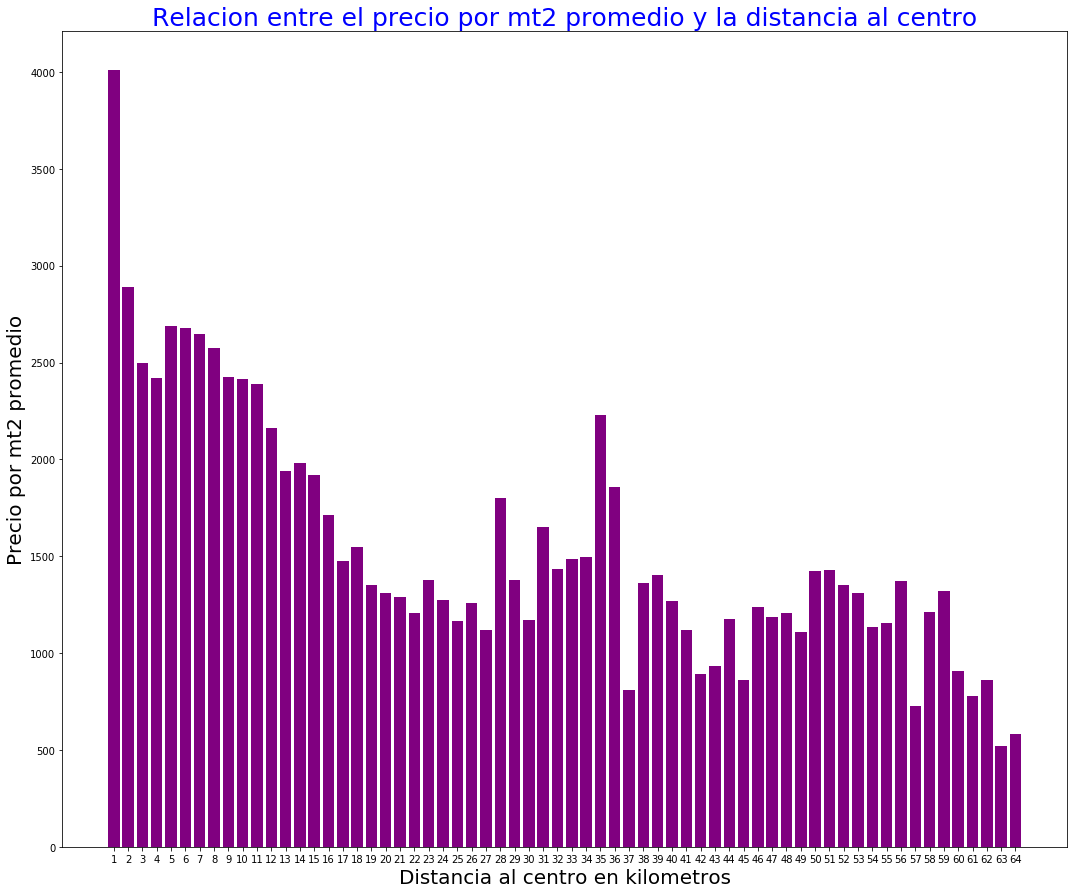

In [280]:
groupbyDistanciaCentro = propiedadesDistanciaCentro.groupby(pd.cut(propiedadesDistanciaCentro['distancia_al_centro'], range(0, 65000, 1000)), as_index= False)
mediaPorDistanciaCentro = groupbyDistanciaCentro['price_usd_per_m2'].agg(['mean'])
distKm = np.arange(groupbyDistanciaCentro.ngroups) + 1
plt.figure(figsize=(18, 15));
plt.bar(distKm, mediaPorDistanciaCentro['mean'], width= 0.8, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia al centro', fontsize = 25, color = 'Blue')
plt.xlabel('Distancia al centro en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)

In [281]:
#Analizo la zona, en la cual el grafico anterior presenta problemas.(28 a 35 km)
zonaProblematica = propiedadesDistanciaCentro.loc[(propiedadesDistanciaCentro.distancia_al_centro < 35000) & (propiedadesDistanciaCentro.distancia_al_centro > 28000), :]\
.groupby('place_name')['price_usd_per_m2'].agg(['mean', 'size'])
zonaProblematica.sort_values('size', ascending = False).head()
#La mayoria de las casas en dicha zona son de Nordelta, el cual es uno de los barrios mas caros, y el cual
#claramente no se ve afectado por la distancia al centro de la ciudad.
#Su precio depende de otro factor. Acceso al Rio? Cercania a el delta del Rio?
#Por lo general, el grafico demuestra una relacion inversamente proporcional entre 
#la distancia al centro y el precio por m2 de la propiedad

mean  size
place_name                   
Nordelta    2440.062640  1317
San Miguel  1260.380025   723
Tigre       1561.687502   515
Ituzaingó    681.406128   396
Muñiz       1299.996365   204

In [282]:
#calcula la distancia en metros entre la propiedad y la villa Fuerte Apache. Recibe por parametro un registro
def distanciaAFuerteApache(geoPos):
      #Ubicacion
    fuerteApache = (-34.622374, -58.539921) #Tomamos este como el punto central de la villa
    return distancia(geoPos, fuerteApache)

def distanciaACarlosGardel(geoPos):
    #Ubicacion
    carlosGardel = (-34.6244, -58.5778) #Tomamos este como el punto central de la villa
    return distancia(geoPos, carlosGardel)

#Informacion sacada de 
#http://blogs.monografias.com/estampas-de-buenos-aires/2015/05/21/las-villas-de-emergencia-en-la-ciudad/
def distanciaAVillas(geoPos):
    
    Indoamericano = (-34.665202, -58.468526)# Se tomaron estas coordenadas ya que alrededor hay una gran cantidad de villas
    return distancia(geoPos, Indoamericano)

In [283]:
propiedadesCercanasAIndoamericano = propiedadesDistancia.copy(deep = True)
propiedadesCercanasAIndoamericano.loc[:, 'distanciaAIndoamericano'] = propiedadesCercanasAIndoamericano['geoPos'].apply(distanciaAVillas)

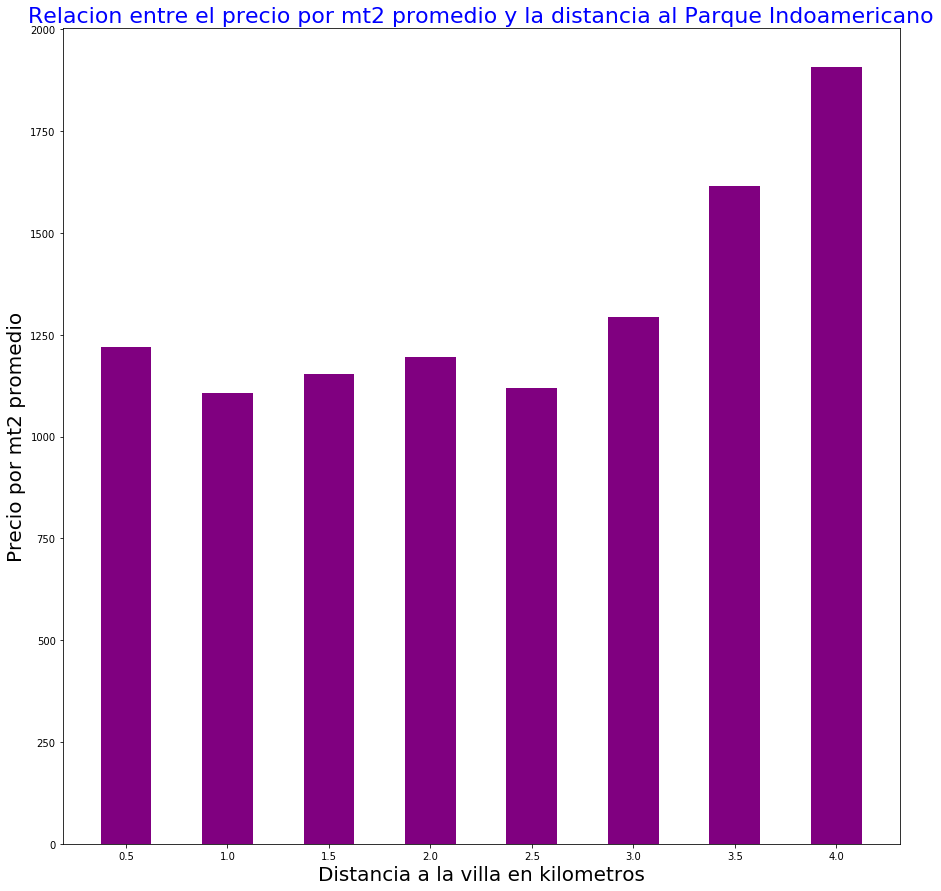

In [284]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasAIndoamericano = propiedadesCercanasAIndoamericano.loc[propiedadesCercanasAIndoamericano['distanciaAIndoamericano'] < 4000, :]
groupbyDistVillas = propiedadesCercanasAIndoamericano.groupby(pd.cut(propiedadesCercanasAIndoamericano['distanciaAIndoamericano'], range(0, 4001, 500)), as_index= False)
mediaPrecioVilla = groupbyDistVillas['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistVillas.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioVilla['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia al Parque Indoamericano', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#No se ve un tendencia clara cuando se analiza las propiedades mas cercanas. 
#Apartir de los 3km se logra ver un aumento en el precio por m2, 
#pero no es seguro determinar que el mismo se deba a la distancia a la concentracion de villas. 
#Otros factores podrian estar influenciando ese cambio.

In [285]:
propiedadesCercanasAFuerteApache = propiedadesDistancia.copy(deep = True)
propiedadesCercanasAFuerteApache.loc[:, 'distanciaAFuerteApache'] = propiedadesCercanasAFuerteApache['geoPos'].apply(distanciaAFuerteApache)

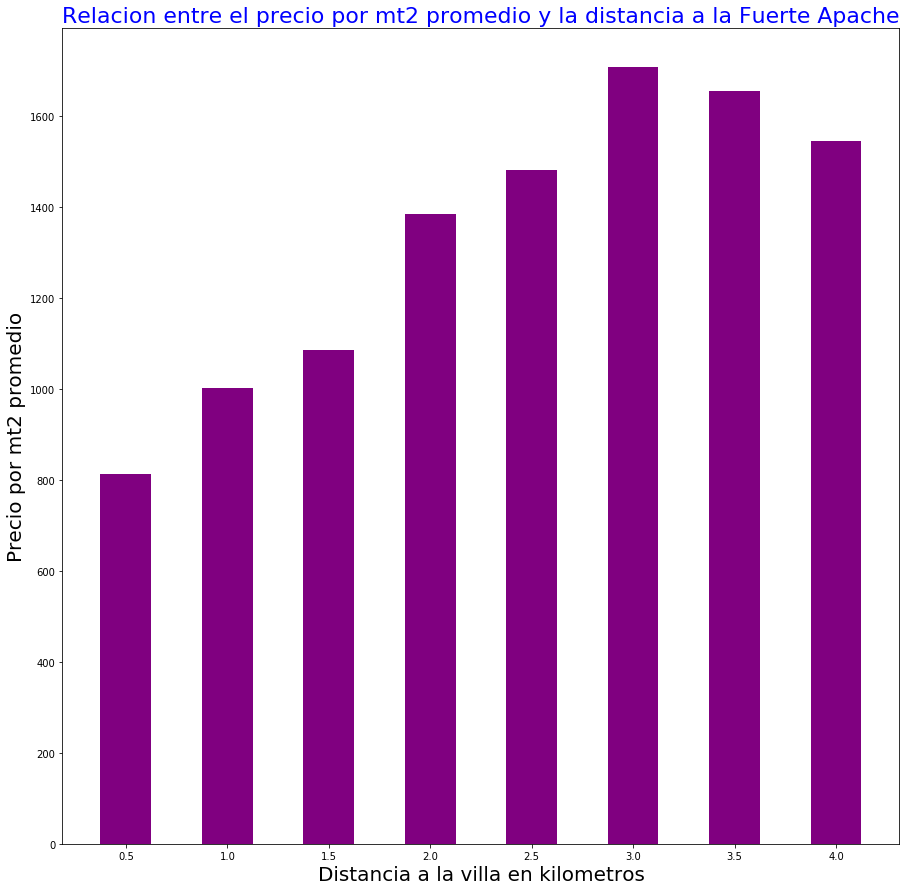

In [286]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasAFuerteApache = propiedadesCercanasAFuerteApache.loc[propiedadesCercanasAFuerteApache['distanciaAFuerteApache'] < 4000, :]
groupbyDistFuerteApache = propiedadesCercanasAFuerteApache.groupby(pd.cut(propiedadesCercanasAFuerteApache['distanciaAFuerteApache'], range(0, 4001, 500)), as_index= False)
mediaPrecioFuerteApache = groupbyDistFuerteApache['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistFuerteApache.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioFuerteApache['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia a la Fuerte Apache', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#En las cercanias de la villa Fuerte Apache se logra ver un notable descenso del precio por m2 de las propiedades.
#Tambien se percibe que el aumento en el precio es considerable mientras se acrecienta la distancia 
#con respecto a la villa.

In [287]:
propiedadesCercanasACarlosGardel = propiedadesDistancia.copy(deep = True)
propiedadesCercanasACarlosGardel.loc[:, 'distanciaACarlosGardel'] = propiedadesCercanasACarlosGardel['geoPos'].apply(distanciaACarlosGardel)

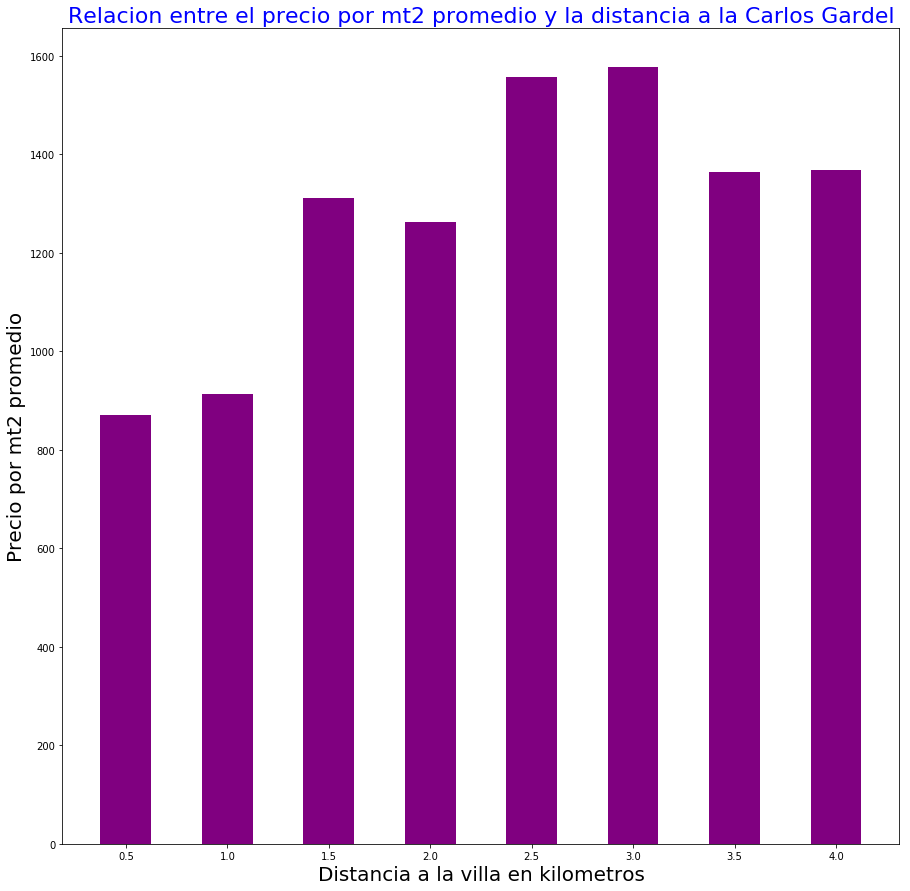

In [288]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasACarlosGardel = propiedadesCercanasACarlosGardel.loc[propiedadesCercanasACarlosGardel['distanciaACarlosGardel'] < 4000, :]
groupbyDistCarlosGardel = propiedadesCercanasACarlosGardel.groupby(pd.cut(propiedadesCercanasACarlosGardel['distanciaACarlosGardel'], range(0, 4001, 500)), as_index= False)
mediaPrecioCarlosGardel = groupbyDistCarlosGardel['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistCarlosGardel.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioCarlosGardel['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia a la Carlos Gardel', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#En las cercanias de la villa Carlos Gardel se logra ver un notable descenso del precio por m2 de las propiedades.
#Tambien se percibe que el aumento en el precio es considerable mientras se acrecienta la distancia 
#con respecto a la villa.

In [289]:
#Relacion entre el precio por m2 y la cercania a estaciones de subtes.

In [290]:
def obtener_subtes_cercanos(geoPos):
    lineaE = [(-34.609563795, -58.374052048), (-34.612989872, -58.377828598),(-34.618217016, -58.381583691), (-34.622366711, -58.385403156),
              (-34.622455000, -58.391432762), (-34.623125994, -58.397119045), (-34.623867613, -58.402848244), (-34.624679854, -58.409628868),
              (-34.625545060, -58.416645527), (-34.626798708, -58.426151276), (-34.628069994, -58.434305191), (-34.631618899, -58.442544937),
              (-34.636385845, -58.450076580), (-34.639563657, -58.457865715), (-34.642829615, -58.461534977)]
    
    lineaA = [(-34.608557137, -58.374567032), (-34.609086958, -58.382549286), (-34.609404849, -58.386669159), (-34.609652097, -58.398342133),
              (-34.609687418, -58.406839371), (-34.610782364, -58.415164948), (-34.615091365, -58.429327011), (-34.611736015, -58.421730995),
              (-34.618022770, -58.435893059), (-34.620459643, -58.441429138), (-34.623567434, -58.448810577), (-34.626533854, -58.456192017)]
    
    lineaB = [(-34.602870174, -58.369545937), (-34.603294060, -58.374567032), (-34.604141827, -58.386712074), (-34.604530384, -58.392891884),
              (-34.604530384, -58.399200439), (-34.604565707, -58.405079842), (-34.604106503, -58.411602974), (-34.603152765, -58.421001434),
              (-34.602057719, -58.430914879), (-34.599055099, -58.439583778), (-34.591671724, -58.447651863), (-34.584111033, -58.466534615),
              (-34.581567095, -58.473873138), (-34.573828804, -58.487434387)]
    
    lineaC = [(-34.590505868, -58.376069069), (-34.595522465, -58.377442360), (-34.602022395, -58.378129005), (-34.608980994, -58.380703926),
              (-34.612407095, -58.380532265), (-34.618058088, -58.380274773), (-34.622331395, -58.379931450), (-34.627964055, -58.381175995)]
    
    lineaD = [(-34.607621111, -58.374266624), (-34.604336105, -58.380360603), (-34.601845773, -58.385360241), (-34.599426017, -58.392827511),
              (-34.599531993, -58.397955894), (-34.594497974, -58.402633667), (-34.591636395, -58.407139778), (-34.588244767, -58.411281109),
              (-34.585170985, -58.415830135), (-34.578440064, -58.426043987), (-34.575295247, -58.434326649), (-34.570242091, -58.444347382),
              (-34.566125132, -58.452243805), (-34.562396722, -58.456299305), (-34.555982053, -58.462092876)]
    
    lineaH = [(-34.588138777, -58.398170471), (-34.598684179, -58.403813839), (-34.603700283, -58.405380249), (-34.608945673, -58.405938148),
              (-34.615515189, -58.404779434), (-34.622896444, -58.402483463), (-34.629341261, -58.400981426), (-34.635255927, -58.399178982),
              (-34.637515748, -58.405981064), (-34.641796880, -58.412622213)]
    
    subtes = lineaA + lineaB + lineaC + lineaD + lineaE + lineaH
    cant_subtes_cercanos = 0
    
    for i in range(len(subtes)):
        if (distancia(geoPos, subtes[i]) <= 700):
            cant_subtes_cercanos += 1
    return cant_subtes_cercanos
    

In [291]:
propiedadesCercanasSubte = propiedadesDistancia.copy(deep = True)
propiedadesCercanasSubte.loc[:,'cant_subtes_cercanos'] = propiedadesCercanasSubte['geoPos'].apply(obtener_subtes_cercanos)

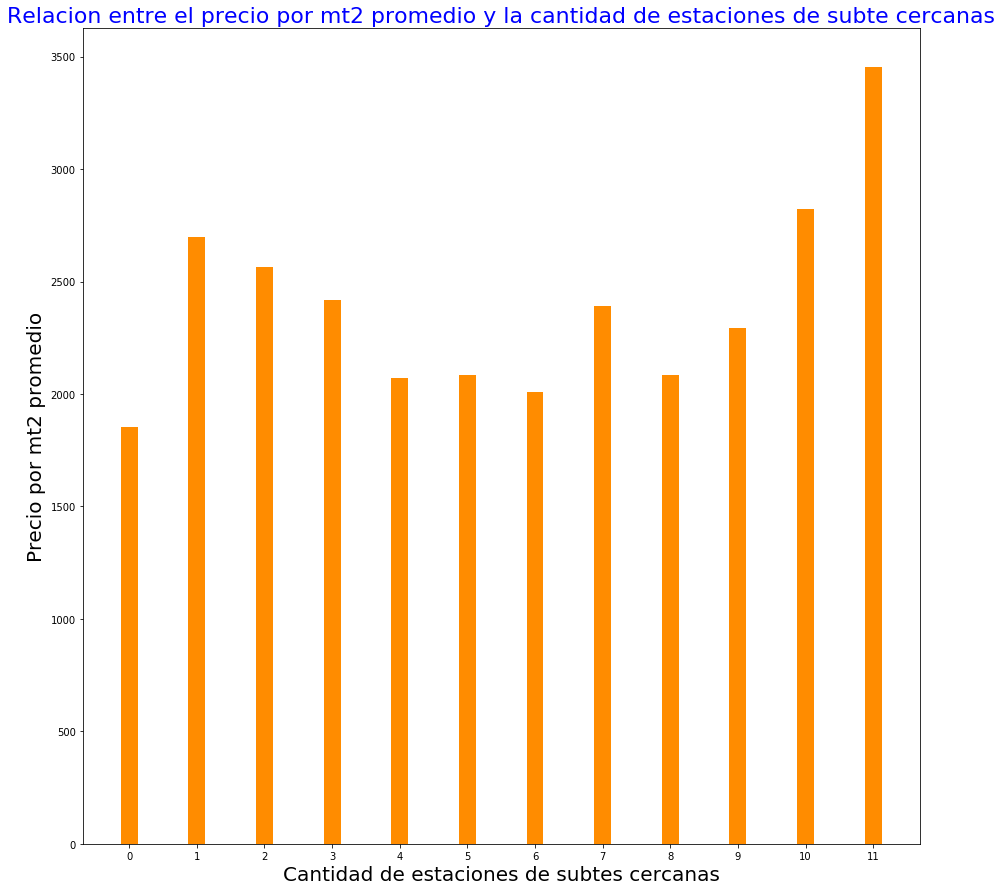

In [292]:
#Las propiedades que tienen al menos una estacion de subte a 700m tienen en promedio mayor precio por m2
groupbySubte = propiedadesCercanasSubte.groupby('cant_subtes_cercanos')
mediaGroupbySubte = groupbySubte['price_usd_per_m2'].agg(['mean'])
#propiedadesConSubte = propiedadesCercanasSubte.loc[propiedadesCercanasSubte['cant_subtes_cercanos'] > 0, :]
#groupbySubte.get_group(0)['price_usd_per_m2'].mean()
#propiedadesConSubte['price_usd_per_m2'].mean()

cant_estaciones = np.arange(groupbySubte.ngroups)

plt.figure(figsize=(15, 15));
plt.bar(cant_estaciones, mediaGroupbySubte['mean'], width= 0.25, color = 'darkorange')
plt.xticks(cant_estaciones, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la cantidad de estaciones de subte cercanas', fontsize = 22, color = 'Blue')
plt.xlabel('Cantidad de estaciones de subtes cercanas', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#Este grafico nos demuestra que las propiedades que tienen al menos una estacion de subte cerca, 
#tienen en promedio un precio por m2 mayor a aquellas que no poseen un estacion de subte cercana.
#Tambien nos informa que no tiene relevancia la cantidad de estaciones cercanas, solo importa que este cerca de una.

In [293]:
def distanciaANuevasEstaciones(reg):
    created_on, place_name, lat, lon, price_usd_per_m2 = reg
    geoPos = lat, lon
    #Ubicacion de las estaciones
    Cordoba = (-34.598691, -58.403841) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015
    SantaFe = (-34.594848, -58.402517) #Inicio Obras: 17 ene 2012 - Inauguracion: 12 jul 2016
    LasHeras = (-34.587879, -58.397970) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015

    distACordoba = distancia(geoPos, Cordoba)
    distASantaFe = distancia(geoPos, SantaFe)
    distALasHeras = distancia(geoPos, LasHeras)
    

    return min(distACordoba, distASantaFe, distALasHeras)

In [294]:
#Aca va lo de los trenes
#Mitre Ramal JL Suarez
Retiro=(-34.589495900, -58.375815000)
3DeFebrero=(-34.571805900, -58.425271100)
Carranza=(-34.575154900, -58.432836300)
Colegiales=(-34.573093100, -58.448278700)
BelgranoR=(-34.567728900, -58.461285900)
Drago=(-34.568478300, -58.479030100)
Urquiza=(-34.574920000, -58.487589000)
VillaPueyrredon=(-34.580332000, -58.501930000)
Miguelete=(-34.582301700, -58.517546400)
SanMartin=(-34.573738900, -58.531764100)
SanAndres=(-34.563129900, -58.540566100)
Malaver=(-34.557439000, -58.547953800)
VillaBallester=(-34.550860200, -58.556444200)
Chilavert=(-34.542311700, -58.567056900)
JoseLeonSuarez=(-34.534233500, -58.576114100)


#Mitre Ramal Mitre
#Retiro=(-34.589495900, -58.375815000)
#3DeFebrero=(-34.571805900, -58.425271100)
#Carranza=(-34.575154900, -58.432836300)
Colegiales=(-34.573093100, -58.448278700)
#BelgranoR=(-34.567728900, -58.461285900)
Coghlan=(-34.565444000, -58.475835000)
Saavedra=(-34.554347600, -58.486654600)
JuanBJusto=(-34.542106100, -58.494398600)
Florida=(-34.529326200, -58.494565900)
Cetrangolo=(-34.523137200, -58.494077700)
Mitre=(-34.514509800, -58.489039400)



#Mitre Ramal Tigre
#Retiro=(-34.589495900, -58.375815000)
LisandroDeLaTorre=(-34.562738100, -58.435664200)
BelgranoC=(-34.558524000, -58.449531000)
Nuniez=(-34.548763000, -58.463060000)
Rivadavia=(-34.536155000, -58.468273900)
VteLopez=(-34.524049100, -58.473396200)
Olivos=(-34.508383800, -58.480840100)
LaLucila=(-34.497587000, -58.488880900)
Martinez=(-34.487893200, -58.497004400)
Acassuso=(-34.479836700, -58.503698100)
SanIsidro=(-34.471657700, -58.514076400)
Beccar=(-34.460823300, -58.526215300)
Victoria=(-34.455746600, -58.540753700)
Virreyes=(-34.450016200, -58.551330000)
SanFernando=(-34.444265500, -58.558544900)
Carupa=(-34.436394400, -58.568376300)
Tigre=(-34.423474500, -58.581848200)

SyntaxError: invalid syntax (<ipython-input-294-a64567d99840>, line 3)